In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from numba import jit, cuda


CAT_COL = ["repeat_retailer", "used_chip", "used_pin_number", "online_order", "fraud"]
NUM_COL = ["distance_from_home", "distance_from_last_transaction", "ratio_to_median_purchase_price"]

## Utils

In [67]:
def plotting(df : pd.DataFrame, col : str):
    df.plot.scatter(x=col, y="fraud")

## Read Data

In [68]:
dataSet = pd.read_csv('card_transdata.csv')
#print levels of every column
for col in dataSet.columns:
    print(col, dataSet[col].unique())

distance_from_home [57.87785658 10.8299427   5.09107949 ...  2.91485699  4.25872939
 58.10812496]
distance_from_last_transaction [0.31114001 0.1755915  0.80515259 ... 1.47268669 0.24202337 0.31811012]
ratio_to_median_purchase_price [1.94593998 1.29421881 0.42771456 ... 0.21807549 0.47582206 0.38691985]
repeat_retailer [1. 0.]
used_chip [1. 0.]
used_pin_number [0. 1.]
online_order [0. 1.]
fraud [0. 1.]


# Notes:

## 1. Payment Methods and Transaction Data

When analyzing transaction data, it's important to consider the different payment methods that may have been used. The `used_chip`, `used_pin_number`, and `online_order` variables can provide valuable insights into the payment methods used for each transaction.

Here are some possible interpretations of different combinations of these variables:

- A row with `used_chip = 0`, `used_pin_number = 0`, and `online_order = 0` could indicate that the payment was made using a wireless payment method, such as a mobile payment app that uses Bluetooth or NFC technology to make payments.

- A row with `used_chip = 1`, `used_pin_number = 0`, and `online_order = 1` could indicate that the payment was made using NFC technology, which allows users to make contactless payments using their smartphones or other devices.

Other combinations of these variables could also indicate the use of alternative payment methods, such as bank transfers, prepaid cards, or cryptocurrency.

When cleaning and preprocessing the data, it's important to carefully consider the implications of missing or incomplete data and to handle outliers appropriately. Additionally, z-score normalization can be used to standardize the scale of variables in the dataset, and feature engineering can be used to create new variables that may improve the predictive power of the model.

Overall, understanding the different payment methods used in the transaction data can help to uncover valuable insights and improve the accuracy and effectiveness of the analysis.

## 2. Outliers:

The `distance_from_home`, `distance_from_last_transaction`, and `ratio_to_median_purchase_price` columns may contain outliers that are valid and meaningful data points. For example, a transaction that is much farther from home or the last transaction may indicate a change in the consumer's behavior or circumstances. Similarly, a purchase that is significantly above or below the median price may reflect the consumer's preferences or availability of products.
Therefore, removing all outliers in these columns may result in a biased or incomplete representation of your data and lead to erroneous conclusions.

## Remove missing data

In [69]:
dataSet.dropna(inplace=True)

## Handle Outliers

c:\Users\EGYPT\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,24.515258,4.182657,1.752482,0.881536,0.350399,0.100608,0.650552,0.087403
std,40.944157,9.552231,2.167108,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.382177,0.015167,0.077271,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,259.943898,65.725606,12.794086,1.000000,1.000000,1.000000,1.000000,1.000000


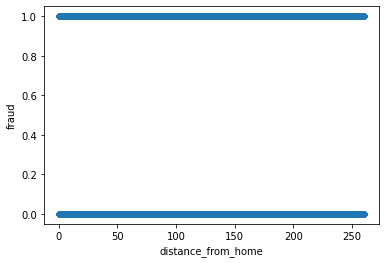

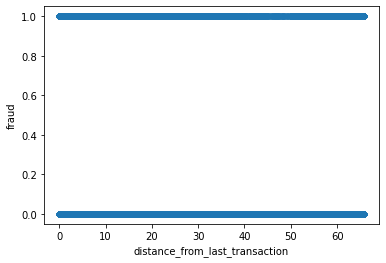

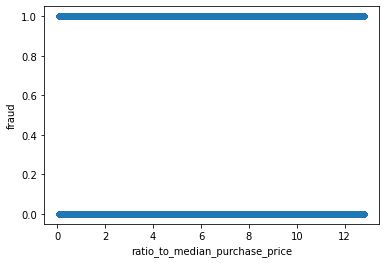

In [70]:
#Handle outliers
def handle_outliers(df):
    # Select numerical columns only
    num_cols = df.select_dtypes(include=[np.number])
    
    # Compute the 1st and 99th percentile of each numerical column
    percentiles = np.nanpercentile(num_cols, [1, 99], axis=0)

    # Winsorize the numerical columns
    num_cols = np.clip(num_cols, percentiles[0], percentiles[1])

    # Replace the original numerical columns in the dataframe with the winsorized ones
    df[num_cols.columns] = num_cols

handle_outliers(dataSet)

for col in NUM_COL:
    plotting(dataSet, col)

dataSet.describe()

## PCA
### Principal Component Analysis

In [72]:
def pca(X):
    # Transform X to numpy
    X = np.array(X)

    # X: (M, N)
    X = X.T

    # Y: (N, M)
    Y = X - np.mean(X, axis=1, keepdims=True)

    # cov: (N, N)
    cov = np.cov(Y, rowvar=True)
    
    #eigenvectors: (N, N)
    eigenvectors, eigenvalues, _ = np.linalg.svd(cov)

    #project data  
    Z = np.matmul(eigenvectors.T, Y)
    #Transform numpy to pandas
    Z = pd.DataFrame(Z.T)
    return Z

dataSet[NUM_COL] = pca(dataSet[NUM_COL])

## Standardize the data

In [55]:
#Standardization using Z-score normalization
def standardize(df):
    result = df.copy()
    for feature_name in df.columns:
        if feature_name in CAT_COL:
            continue
        mean_value = df[feature_name].mean()
        std_value = df[feature_name].std()
        result[feature_name] = (df[feature_name] - mean_value) / std_value
    return result

## Split the data

In [56]:
# Split the data
dataSet = standardize(dataSet)
x_train, x_test, y_train, y_test = train_test_split(dataSet.drop('fraud',axis=1), dataSet['fraud'],
                                                     test_size=0.2, random_state=42)
# Convert the data into numpy arrays
x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values

## Parameters definition

In [57]:
#Number of features
N = x_train.shape[1]
print(f'Number of features = {N}')

#Number of training examples
M = x_train.shape[0]
print(f'Number of training examples = {M}')

#Number of testing examples
M_test = x_test.shape[0]
print(f'Number of testing examples = {M_test}')

#Number of classes
K = len(np.unique(y_train))
print(f'Number of classes = {K}')

# Print shapes of training and testing data
print(f'Shape of x_train = {x_train.shape} = (M, N)')
print(f'Shape of y_train = {y_train.shape} = (M, )')
print(f'Shape of x_test = {x_test.shape} = (M_test, N)')
print(f'Shape of y_test = {y_test.shape} = (M_test, )')

Number of features = 7
Number of training examples = 800000
Number of testing examples = 200000
Number of classes = 2
Shape of x_train = (800000, 7) = (M, N)
Shape of y_train = (800000,) = (M, )
Shape of x_test = (200000, 7) = (M_test, N)
Shape of y_test = (200000,) = (M_test, )


## Logistic regression

In [58]:
# Implement logistic regression
logisticRegr = LogisticRegression(max_iter=1000)
logisticRegr.fit(x_train, y_train)
# predictions = logisticRegr.predict(x_test)
# print("Logistic regression predictions: ", predictions[:10])
score = logisticRegr.score(x_test, y_test)
print(f"Logisitic regression score: {round(score*100, 2)}%")

Logisitic regression score: 96.28%


In [59]:
# Get user input for one transaction
def predict_single(model ,distance_from_home, distance_from_last_transaction, 
                       ratio_to_median_purchase_price, repeat_retailer, used_chip, 
                       used_pin_number, online_order):
    # distance_from_home = 270
    # distance_from_last_transaction = 500
    # ratio_to_median_purchase_price = 1.2
    # repeat_retailer = 0
    # used_chip = 1
    # used_pin_number = 0
    # online_order = 0

    # row ha shape (1, N)
    row = np.array([[ distance_from_home,
                    distance_from_last_transaction,
                    ratio_to_median_purchase_price,
                    repeat_retailer,
                    used_chip, used_pin_number, online_order]])
    
    prediction = int(model.predict(row))
    return prediction

print(f'Prediction: {predict_single(logisticRegr, 5, 1, 0.8, 0, 1, 1, 0)}')

Prediction: 0


## Minimum Distance Classifier

In [60]:
def calculateDistance(x1, x2):
    # Euclidean distance
    distance = np.linalg.norm(x1-x2)
    return distance

In [61]:
def MinimumDistanceClassifier(test_points, training_features, labels):
    # INPUTS:   test_points: (M_test, N)  
    #           training_features: (M, N)
    #           labels: (M, )
    
    # OUTPUTS:  classification: an integer indicating the classification of the test point
    #                           either 0 (No Fraud) or 1 (Fraud)
      
    
    zeros_mean = np.mean(training_features[labels == 0], axis = 0)
    ones_mean = np.mean(training_features[labels == 1], axis = 0)

    zeros_dist = calculateDistance(zeros_mean, test_points)
    ones_dist = calculateDistance(ones_mean, test_points)

    if zeros_dist < ones_dist:
        classification = 0
    else:
        classification = 1
    
    return classification

mdc_accuracy = 0


predictions = MinimumDistanceClassifier(x_test, x_train, y_train)
mdc_accuracy = np.mean(predictions == y_test)
print(f'Minimum Distance Classifier accuracy: {round(mdc_accuracy*100, 2)}%')

Minimum Distance Classifier accuracy: 91.28%


## KNN

In [62]:
# function optimized to run on gpu 
@jit
def KNN(test_points, training_features, labels, k):
    # INPUTS:   test_points: (M_test, N)
    #           training_features: (M, N)
    #           k: the number of nearest neighbours. 
    
    # OUTPUTS:  classification: an integer indicating the classification of the test point
    #                           either 0 (No Fraud) or 1 (Fraud)

    distances = [calculateDistance(test_points, p) for p in training_features]

    # distances = np.sqrt(((test_points[:, np.newaxis, :] - training_features) ** 2).sum(axis=2))
    
    k_nearest = np.argpartition(distances, k)[:k]
    
    zeros_votes = 0
    ones_votes = 0

    for i in k_nearest:
        if (labels[i] == 0):
            zeros_votes += 1
        if (labels[i] == 1):
            ones_votes += 1

    if (zeros_votes > ones_votes):
        classification = 0
    else:
        classification = 1

    return classification

predictions_3 = KNN(x_test, x_train, y_train, 3)
predictions_5 = KNN(x_test, x_train, y_train, 5)

knn_accuracy_3 = np.mean(predictions_3 == y_test)
knn_accuracy_5 = np.mean(predictions_5 == y_test)

print(f'KNN accuracy with k = 3: {round(knn_accuracy_3*100, 2)}%')
print(f'KNN accuracy with k = 5: {round(knn_accuracy_5*100, 2)}%')

C:\Users\EGYPT\AppData\Local\Temp\ipykernel_14344\2138470555.py:3: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def KNN(test_points, training_features, labels, k):
C:\Users\EGYPT\AppData\Local\Temp\ipykernel_14344\2138470555.py:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "KNN" failed type inference due to: Untyped global name 'calculateDistance': Cannot determine Numba type of <class 'function'>

File "C:\Users\EGYPT\AppData\Local\Temp\ipykernel_14344\2138470555.py", line 11:
def KNN(test_points, training_features, labels, k):
    <source elided>

    distances = [calculateDistance(test_points, p) for p in training

KeyboardInterrupt: 

## Naïve Bayes

In [63]:
a_priori_prob_zeros = np.sum(y_train == 0) / M
a_priori_prob_ones = np.sum(y_train == 1) / M

estimate_means_zeros = np.mean(x_train[y_train == 0], axis = 0)
estimate_means_ones = np.mean(x_train[y_train == 1], axis = 0)

estimate_covariance_zeros = np.cov(x_train[y_train == 0], rowvar = False)
estimate_covariance_ones = np.cov(x_train[y_train == 1], rowvar = False)

#Print shape of all variables
print(f'Shape of estimate_means_zeros = {estimate_means_zeros.shape} = (N, )')
print(f'Shape of estimate_means_ones = {estimate_means_ones.shape} = (N, )')
print(f'Shape of estimate_covariance_zeros = {estimate_covariance_zeros.shape} = (N, N)')
print(f'Shape of estimate_covariance_ones = {estimate_covariance_ones.shape} = (N, N)')

Shape of estimate_means_zeros = (7,) = (N, )
Shape of estimate_means_ones = (7,) = (N, )
Shape of estimate_covariance_zeros = (7, 7) = (N, N)
Shape of estimate_covariance_ones = (7, 7) = (N, N)


In [64]:
def multivariate_normal_gaussian(X, mu, sigma):
    prob = (1 / ( (2*np.pi)**(N/2) * np.sqrt(np.linalg.det(sigma)))) * np.exp((-1/2) * np.matmul((X - mu).T, np.matmul(np.linalg.inv(sigma), (X - mu))))
    return prob

In [65]:
def predict_naive_gaussian(test_point):
    # INPUTS:   test_point: (N, )
    
    # OUTPUTS:  classification: an integer indicating the classification of the test point
    #                           either 0 (No Fraud) or 1 (Fraud)
    
    prob_zeros = multivariate_normal_gaussian(test_point, estimate_means_zeros, estimate_covariance_zeros)
    prob_ones = multivariate_normal_gaussian(test_point, estimate_means_ones, estimate_covariance_ones)

    if prob_zeros > prob_ones:
        classification = 0
    else:
        classification = 1
    
    return classification

naive_bayes_accuracy = 0
for i in range(len(x_test)):
    classification = predict_naive_gaussian(x_test[i])
    if (classification == y_test[i]):
        naive_bayes_accuracy += 1
naive_bayes_accuracy /= len(x_test)
print(f'Naive Bayes accuracy: {round(naive_bayes_accuracy*100, 2)}%')

Naive Bayes accuracy: 87.41%
